In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join('..', 'input')
stage_label = 'stage1'

In [3]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))

In [4]:
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])

In [5]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
14050,../input/stage1_train/b1eb0123fe2d8c825694b193...,b1eb0123fe2d8c825694b193efb7b923d95effac9558ee...,masks,train,stage1
12034,../input/stage1_train/cb4df20a83b2f38b394c67f1...,cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3...,masks,train,stage1


In [6]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))

CPU times: user 28.9 s, sys: 1.78 s, total: 30.6 s
Wall time: 34.5 s


In [7]:
train_img_df.sample(1)

,ImageId,Stage,images,masks
18,072ff14c1d3245bf49ad6f1d4c71cdb18f1cb78a8e06fd...,stage1,"[[[0.0117647058824, 0.0117647058824, 0.0117647...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [11]:
np.shape(train_img_df['images'][0])

(256, 256, 3)

In [66]:
X=train_img_df['images']
Y=train_img_df['masks']
a=X.as_matrix()
X[0]

array([[[ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01960784,  0.01960784,  0.01960784],
        ..., 
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01176471,  0.01176471,  0.01176471],
        [ 0.01176471,  0.01176471,  0.01176471]],

       [[ 0.02352941,  0.02352941,  0.02352941],
        [ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01960784,  0.01960784,  0.01960784],
        ..., 
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01176471,  0.01176471,  0.01176471]],

       [[ 0.02352941,  0.02352941,  0.02352941],
        [ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01960784,  0.01960784,  0.01960784],
        ..., 
        [ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01176471,  0.01176471,  0.01176471]],

       ..., 
       [[ 0.01176471,  0.01176471,  0.01176471],
        

In [80]:
from skimage.transform import resize

l=X.shape[0]
images=[None]*l
masks=[None]*l
for i in range(l):
    images[i]=resize(X[i],(256, 256,3), mode='constant', preserve_range=True)
    masks[i]=resize(Y[i],(256, 256,1), mode='constant', preserve_range=True)
    masks[i]=masks[i].astype(int)
    
images=np.asarray(images)
masks=np.asarray(masks)

# images=np.concatenate(images,axis=0)
# masks=np.concatenate(masks,axis=0)

In [128]:
images[0].shape
masks.shape

(670, 256, 256, 1)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [82]:


from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
model = Sequential()
model.add(BatchNormalization(input_shape = (256, 256, 3), 
                                  name = 'NormalizeInput'))
model.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
model.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
# use dilations to get a slightly larger field of view
model.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
model.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

# the final processing
model.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
model.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 256, 256, 8)       584       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 256, 256, 16)      1168      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 256, 256, 16)      528       
__________

In [83]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [84]:
model.fit(images,masks)

Epoch 1/10
670/670 [==============================] - 99s - loss: 0.5000 - acc: 0.7840    
Epoch 2/10
670/670 [==============================] - 94s - loss: 0.3580 - acc: 0.8694    
Epoch 3/10
670/670 [==============================] - 94s - loss: 0.3393 - acc: 0.8743    
Epoch 4/10
670/670 [==============================] - 96s - loss: 0.3211 - acc: 0.8831    
Epoch 5/10
670/670 [==============================] - 94s - loss: 0.2989 - acc: 0.8943    
Epoch 6/10
670/670 [==============================] - 94s - loss: 0.2798 - acc: 0.9053    
Epoch 7/10
670/670 [==============================] - 95s - loss: 0.2701 - acc: 0.9097    
Epoch 8/10
670/670 [==============================] - 95s - loss: 0.2754 - acc: 0.9086    
Epoch 9/10
670/670 [==============================] - 95s - loss: 0.2656 - acc: 0.9125    
Epoch 10/10
670/670 [==============================] - 95s - loss: 0.2628 - acc: 0.9143    


In [153]:

images[1:2,:,:,:]
p=model.predict(images[5:6,:,:,:])
p=p[0,:,:,0]
p.shape

(256, 256)

In [159]:
images[1:2,:,:,:].shape

(1, 256, 256, 3)

In [123]:
p

array([[ 0.19329433,  0.16240408,  0.13567562, ...,  0.12285695,
         0.13295954,  0.16113703],
       [ 0.20411317,  0.16414572,  0.12689263, ...,  0.10215145,
         0.11492375,  0.15869655],
       [ 0.16907933,  0.12323346,  0.09385417, ...,  0.09563072,
         0.11049543,  0.15298377],
       ..., 
       [ 0.19664577,  0.19238484,  0.15427722, ...,  0.10931989,
         0.15449119,  0.15264128],
       [ 0.16549689,  0.16758621,  0.13912554, ...,  0.1575571 ,
         0.21149664,  0.20014483],
       [ 0.20203349,  0.21650185,  0.18175137, ...,  0.16097085,
         0.20341112,  0.19073872]], dtype=float32)

In [154]:
from skimage.filters import threshold_otsu

thresh_val = threshold_otsu(p)
a = np.where(p > thresh_val, 1, 0)

In [155]:
b=np.where(p>0.5,1,0)

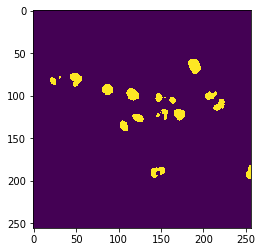

In [156]:
plt.imshow(a)

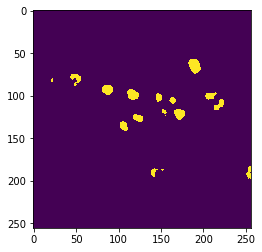

In [157]:
plt.imshow(b)

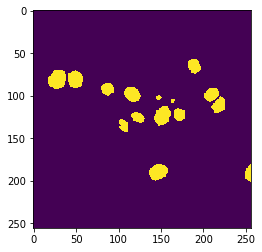

In [152]:
plt.imshow(masks[5,:,:,0])

In [121]:
images[0]

array([[[ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01960784,  0.01960784,  0.01960784],
        ..., 
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01176471,  0.01176471,  0.01176471],
        [ 0.01176471,  0.01176471,  0.01176471]],

       [[ 0.02352941,  0.02352941,  0.02352941],
        [ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01960784,  0.01960784,  0.01960784],
        ..., 
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01176471,  0.01176471,  0.01176471]],

       [[ 0.02352941,  0.02352941,  0.02352941],
        [ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01960784,  0.01960784,  0.01960784],
        ..., 
        [ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01176471,  0.01176471,  0.01176471]],

       ..., 
       [[ 0.01176471,  0.01176471,  0.01176471],
        

In [104]:
type(images)

numpy.ndarray

In [105]:
type(images[0])

numpy.ndarray

In [158]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [168]:
import cv2
import pandas as pd
from scipy import ndimage

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = cv2.imread(str(im_path),1)
    im=resize(im,(256,256,3))
    im=np.array([im])
    #im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    
    p = model.predict(im)
    p=p[0,:,:,0]
    
    
    thresh_val = threshold_otsu(p)
    mask = np.where(p > thresh_val, 1, 0)
    
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [169]:
import pathlib
import time
t0 = time.time()

testing = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submissionCNN.csv', index=None)

t1=time.time()
total=t1-t0
print(total)

10.4269208908


In [167]:
np.array([images[0]]).shape

(1, 256, 256, 3)

In [171]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
model1 = Sequential()
model1.add(BatchNormalization(input_shape = (256, 256, 3), 
                                  name = 'NormalizeInput'))
model1.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
model1.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))

model1.add(Conv2D(16, kernel_size = (3,3), padding = 'same'))
model1.add(Conv2D(16, kernel_size = (3,3), padding = 'same'))

model1.add(Conv2D(32, kernel_size = (3,3), padding = 'same'))
model1.add(Conv2D(32, kernel_size = (3,3), padding = 'same'))

model1.add(Conv2D(64, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
model1.add(Conv2D(64, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

model1.add(Conv2D(128, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
model1.add(Conv2D(128, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

model1.add(Conv2D(64, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
model1.add(Conv2D(64, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

model1.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
model1.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

model1.add(Conv2D(8, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
model1.add(Conv2D(8, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

model1.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 256, 256, 8)       584       
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 256, 256, 16)      1168      
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 256, 256, 32)      9248      
__________

In [173]:
model1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [174]:
model1.fit(images, masks, validation_split=0.1, batch_size=8, epochs=5)

Train on 603 samples, validate on 67 samples
Epoch 1/5
603/603 [==============================] - 1871s - loss: 0.8176 - acc: 0.8049 - val_loss: 0.4011 - val_acc: 0.8220
Epoch 2/5
603/603 [==============================] - 1892s - loss: 0.4515 - acc: 0.8674 - val_loss: 0.3095 - val_acc: 0.8883
Epoch 3/5
603/603 [==============================] - 1881s - loss: 0.3850 - acc: 0.8791 - val_loss: 0.3022 - val_acc: 0.8941
Epoch 4/5
603/603 [==============================] - 1896s - loss: 0.4017 - acc: 0.8862 - val_loss: 0.3488 - val_acc: 0.8965
Epoch 5/5
603/603 [==============================] - 1871s - loss: 0.3381 - acc: 0.8912 - val_loss: 0.3842 - val_acc: 0.8777


In [183]:
images[1:2,:,:,:]
p=model1.predict(images[0:1,:,:,:])
p=p[0,:,:,0]
p.shape

(256, 256)

In [184]:
from skimage.filters import threshold_otsu

thresh_val = threshold_otsu(p)
a = np.where(p > thresh_val, 1, 0)

In [185]:
b=np.where(p>0.3,1,0)

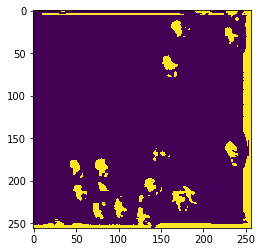

In [186]:
plt.imshow(a)

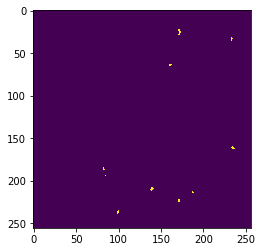

In [187]:
plt.imshow(b)

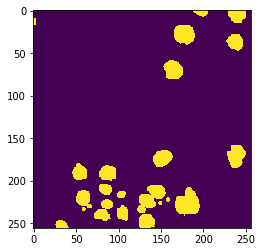

In [189]:
plt.imshow(masks[0,:,:,0])

In [197]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [190]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [201]:
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
K.clear_session()

# Build U-Net model
inputs = Input((256, 256, 3))
s = Lambda(lambda x: x ) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 256, 256, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 8)   224         lambda_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 256, 256, 8)   584         conv2d_1[0][0]                   
___________________________________________________________________________________________

In [202]:
model.fit(images, masks, validation_split=0.1, batch_size=8, epochs=5)

Train on 603 samples, validate on 67 samples
Epoch 1/5
603/603 [==============================] - 98s - loss: 0.3595 - my_iou_metric: 0.0000e+00 - val_loss: 0.1821 - val_my_iou_metric: 0.0000e+00
Epoch 2/5
603/603 [==============================] - 98s - loss: 0.2230 - my_iou_metric: 6.6335e-04 - val_loss: 0.2108 - val_my_iou_metric: 0.0269
Epoch 3/5
603/603 [==============================] - 101s - loss: 0.2200 - my_iou_metric: 0.0192 - val_loss: 0.1653 - val_my_iou_metric: 0.0358
Epoch 4/5
603/603 [==============================] - 100s - loss: 0.1614 - my_iou_metric: 0.0244 - val_loss: 0.1409 - val_my_iou_metric: 0.0075
Epoch 5/5
603/603 [==============================] - 106s - loss: 0.1403 - my_iou_metric: 0.0337 - val_loss: 0.1104 - val_my_iou_metric: 0.0403


In [209]:
images[1:2,:,:,:]
p=model.predict(images[10:11,:,:,:])
p=p[0,:,:,0]
p.shape

(256, 256)

In [210]:
from skimage.filters import threshold_otsu

thresh_val = threshold_otsu(p)
a = np.where(p > thresh_val, 1, 0)

In [211]:
b=np.where(p>0.5,1,0)

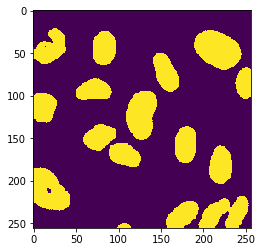

In [212]:
plt.imshow(a)

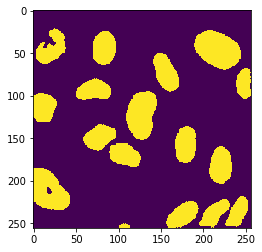

In [213]:
plt.imshow(b)

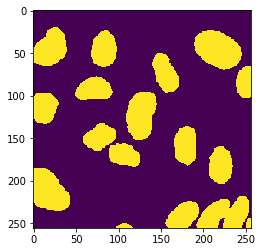

In [215]:
plt.imshow(masks[10,:,:,0])

In [216]:
import cv2
import pandas as pd
from scipy import ndimage

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = cv2.imread(str(im_path),1)
    im=resize(im,(256,256,3))
    im=np.array([im])
    #im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    
    p = model.predict(im)
    p=p[0,:,:,0]
    
    
    thresh_val = threshold_otsu(p)
    mask = np.where(p > thresh_val, 1, 0)
    
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [217]:
import pathlib
import time
t0 = time.time()

testing = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submissionUnet.csv', index=None)

t1=time.time()
total=t1-t0
print(total)

8.56752705574


In [218]:
model.fit(images, masks, validation_split=0.1, batch_size=8, epochs=10)

Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - 96s - loss: 0.1139 - my_iou_metric: 0.0358 - val_loss: 0.1150 - val_my_iou_metric: 0.0701
Epoch 2/10
603/603 [==============================] - 97s - loss: 0.1060 - my_iou_metric: 0.0464 - val_loss: 0.1333 - val_my_iou_metric: 0.0164
Epoch 3/10
603/603 [==============================] - 99s - loss: 0.0936 - my_iou_metric: 0.0469 - val_loss: 0.1054 - val_my_iou_metric: 0.0358
Epoch 4/10
603/603 [==============================] - 98s - loss: 0.0928 - my_iou_metric: 0.0499 - val_loss: 0.1489 - val_my_iou_metric: 0.0104
Epoch 5/10
603/603 [==============================] - 97s - loss: 0.0868 - my_iou_metric: 0.0516 - val_loss: 0.0783 - val_my_iou_metric: 0.0731
Epoch 6/10
603/603 [==============================] - 98s - loss: 0.0790 - my_iou_metric: 0.0504 - val_loss: 0.2233 - val_my_iou_metric: 0.0015
Epoch 7/10
603/603 [==============================] - 98s - loss: 0.0789 - my_iou_metric: 0

In [225]:
images[1:2,:,:,:]
p=model.predict(images[100:101,:,:,:])
p=p[0,:,:,0]
p.shape

(256, 256)

In [226]:
from skimage.filters import threshold_otsu

thresh_val = threshold_otsu(p)
a = np.where(p > thresh_val, 1, 0)

In [227]:
b=np.where(p>0.5,1,0)

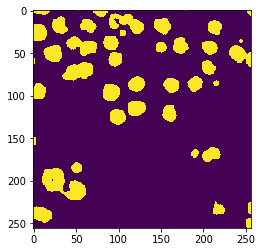

In [228]:
plt.imshow(a)

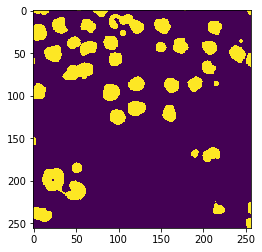

In [229]:
plt.imshow(b)

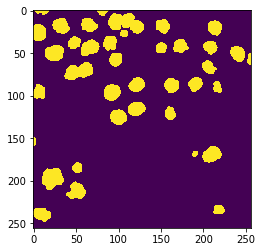

In [231]:
plt.imshow(masks[100,:,:,0])

In [232]:
import cv2
import pandas as pd
from scipy import ndimage

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = cv2.imread(str(im_path),1)
    im=resize(im,(256,256,3))
    im=np.array([im])
    #im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    
    p = model.predict(im)
    p=p[0,:,:,0]
    
    
    thresh_val = threshold_otsu(p)
    mask = np.where(p > thresh_val, 1, 0)
    
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [233]:
import pathlib
import time
t0 = time.time()

testing = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submissionUnet1.csv', index=None)

t1=time.time()
total=t1-t0
print(total)

9.75243377686


In [234]:
model.fit(images, masks, validation_split=0.1, batch_size=8, epochs=20)

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - 97s - loss: 0.0717 - my_iou_metric: 0.0574 - val_loss: 0.0703 - val_my_iou_metric: 0.0746
Epoch 2/20
603/603 [==============================] - 102s - loss: 0.0724 - my_iou_metric: 0.0519 - val_loss: 0.0711 - val_my_iou_metric: 0.0746
Epoch 3/20
603/603 [==============================] - 117s - loss: 0.0719 - my_iou_metric: 0.0569 - val_loss: 0.0757 - val_my_iou_metric: 0.0806
Epoch 4/20
603/603 [==============================] - 126s - loss: 0.0689 - my_iou_metric: 0.0642 - val_loss: 0.0673 - val_my_iou_metric: 0.0343
Epoch 5/20
603/603 [==============================] - 153s - loss: 0.0687 - my_iou_metric: 0.0619 - val_loss: 0.0696 - val_my_iou_metric: 0.0821
Epoch 6/20
603/603 [==============================] - 156s - loss: 0.0686 - my_iou_metric: 0.0609 - val_loss: 0.0732 - val_my_iou_metric: 0.0657
Epoch 7/20
603/603 [==============================] - 176s - loss: 0.0677 - my_iou_met

In [247]:
images[1:2,:,:,:]
p=model.predict(images[500:501,:,:,:])
p=p[0,:,:,0]
p.shape

(256, 256)

In [248]:
from skimage.filters import threshold_otsu

thresh_val = threshold_otsu(p)
a = np.where(p > thresh_val, 1, 0)

In [249]:
b=np.where(p>0.5,1,0)

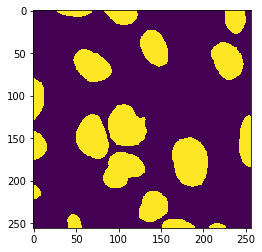

In [250]:
plt.imshow(a)

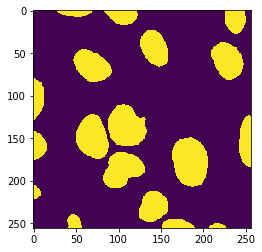

In [251]:
plt.imshow(b)

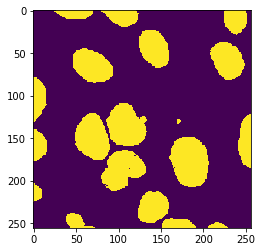

In [253]:
plt.imshow(masks[500,:,:,0])

In [254]:
import cv2
import pandas as pd
from scipy import ndimage

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = cv2.imread(str(im_path),1)
    im=resize(im,(256,256,3))
    im=np.array([im])
    #im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    
    p = model.predict(im)
    p=p[0,:,:,0]
    
    
    #thresh_val = threshold_otsu(p)
    mask = np.where(p > 0.5, 1, 0)
    
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [255]:
import pathlib
import time
t0 = time.time()

testing = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submissionUnet2.csv', index=None)

t1=time.time()
total=t1-t0
print(total)

9.60887002945


In [256]:
model.fit(images, masks, validation_split=0.1, batch_size=8, epochs=20)

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - 96s - loss: 0.0583 - my_iou_metric: 0.0567 - val_loss: 0.0697 - val_my_iou_metric: 0.0269
Epoch 2/20
603/603 [==============================] - 102s - loss: 0.0576 - my_iou_metric: 0.0627 - val_loss: 0.0657 - val_my_iou_metric: 0.0731
Epoch 3/20
603/603 [==============================] - 99s - loss: 0.0562 - my_iou_metric: 0.0594 - val_loss: 0.0624 - val_my_iou_metric: 0.0896
Epoch 4/20
603/603 [==============================] - 98s - loss: 0.0557 - my_iou_metric: 0.0590 - val_loss: 0.0698 - val_my_iou_metric: 0.1149
Epoch 5/20
603/603 [==============================] - 98s - loss: 0.0553 - my_iou_metric: 0.0625 - val_loss: 0.0724 - val_my_iou_metric: 0.1313
Epoch 6/20
603/603 [==============================] - 98s - loss: 0.0553 - my_iou_metric: 0.0675 - val_loss: 0.0617 - val_my_iou_metric: 0.0627
Epoch 7/20
603/603 [==============================] - 97s - loss: 0.0534 - my_iou_metric: 

In [275]:
i=600
images[1:2,:,:,:]
p=model.predict(images[i:i+1,:,:,:])
p=p[0,:,:,0]
p.shape

(256, 256)

In [276]:
from skimage.filters import threshold_otsu

thresh_val = threshold_otsu(p)
a = np.where(p > thresh_val, 1, 0)

In [277]:
b=np.where(p>0.5,1,0)

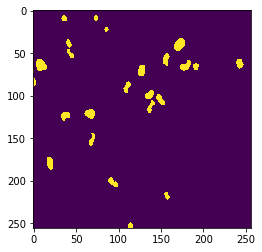

In [278]:
plt.imshow(a)

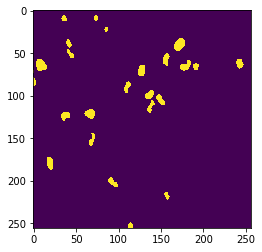

In [279]:
plt.imshow(b)

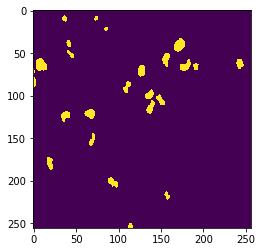

In [280]:
plt.imshow(masks[i,:,:,0])

In [281]:
import cv2
import pandas as pd
from scipy import ndimage

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = cv2.imread(str(im_path),1)
    im=resize(im,(256,256,3))
    im=np.array([im])
    #im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    
    p = model.predict(im)
    p=p[0,:,:,0]
    
    
    #thresh_val = threshold_otsu(p)
    mask = np.where(p > 0.5, 1, 0)
    
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [282]:
import pathlib
import time
t0 = time.time()

testing = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submissionUnet3.csv', index=None)

t1=time.time()
total=t1-t0
print(total)

9.86771607399
